# CSCA-5028: Application of Software Architecture for Big Data #
    
* Author: Alexander Meau  
* Email: alme9155@colorado.edu  
* GitHub: [https://github.com/alme9155/csca-5028-sentiment-analysis](https://github.com/alme9155/csca-5028-sentiment-analysis)  

## I. Brief description of the problem and data ##


### **Project Name**: AI-Powered Movie Sentiment Rating System ###
This project aims to fine-tune a pre-trained NLP model and adapt the natural language processor to provide proper ratings based on review text. This notebook offers a development playground for the software project.

* **What problem is the product aimed at solving?**
  * This product aims to address the challenges of generating accurate rating scores for movie review text.

* **Who is the product geared towards (targeted audience)?**
  * The primary target audience is online movie platforms, such as Netflix or Amazon Prime, to use these ratings in their recommender system.

* **How is the product unique?**
  * This product is unique in its application of transfer learning, where a pre-trained NLP model is fine-tuned for the domain of movie reviews.



### Dataset: ####
* Stanford Sentiment Treebank Class 5(SST-5):
  * SST-5 is a fine-grained sentiment analysis dataset derived from Rotten Tomatoes movie review snipplets created by Stanford NLP Laboratory.
  * This is a fine-grained sentiment analysis dataset because the sentiment labels are broken down to 5 rating categories. Most of the sentiment dataset only has classification between 0 and 1 (positive/negative).
  * Rating categories range from 0-5: very negative, negative, neutral, positive, or very positive.

  
### Data Size and Dimension ####
* The dataset is organized into 3 splits: *Train*, *Validation*, *Test*.
* The *Train* split contains 8544 sentence samples.
* Each sample includes:
  * **"text"**: The review text
  * **"label"**: Numeric sentiment class (0-5)
  * **"label_text"**: Corresponding sentiment class label (e.g. very positive).
* Example: "This is a great movie", 4, "very positive"

In [1]:
# Step 1: Install PyTorch with CUDA 11.8 (required for GPU), and latest Hugginf Face system
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q -U "transformers>=4.44.0" "datasets>=3.0.0" "accelerate>=0.33.0" "evaluate>=0.4.0" scikit-learn

import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 43.2 MB/s eta 0:00:00
PyTorch: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


## II. Exploratory Data Analysis (EDA) ##
- Examine video quality:
  - Dimension (width x height)
  - Frame Count and Frame per secound
  - Total count of video clips
  - Total count of video category

In [3]:
from google.colab import userdata
userdata.get('HF_TOKEN')

from datasets import load_dataset
ds = load_dataset("SetFit/sst5")
ds

README.md:   0%|          | 0.00/421 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl: 0.00B [00:00, ?B/s]

dev.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})

In [4]:
from datasets import load_dataset
import pandas as pd
from IPython.display import display

print("========== DATASET DIMENSIONS ==========\n")
print(f"Number of rows (samples): {len(ds["train"])}")
print(f"Number of columns (features): {len(ds["train"].features)}\n")

print("Feature schema:")
print(ds["train"].features)

#df_train_head = ds["train"].to_pandas().head(10)
#display(df_train_head)

# Show a few training samples
for i in range(3):
    print(f"\nExample {i}:")
    print("Text :", ds["train"][i]["text"])
    print("Label:", ds["train"][i]["label"])

========== DATASET DIMENSIONS ==========

Number of rows (samples): 8544
Number of columns (features): 3

Feature schema:
{'text': Value('string'), 'label': Value('int64'), 'label_text': Value('string')}

Example 0:
Text : a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
Label: 4

Example 1:
Text : apparently reassembled from the cutting-room floor of any given daytime soap .
Label: 1

Example 2:
Text : they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .
Label: 1


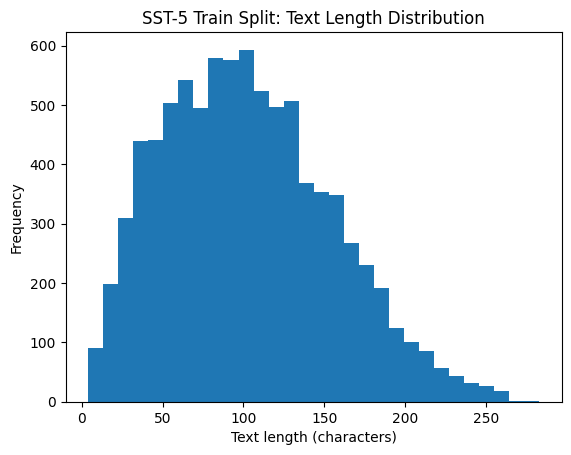


"Train" split "text" length (characters):
  mean: 102.7
  std : 51.7
  min : 4
  max : 283
  25th percentile: 62.0
  50th percentile: 98.0
  75th percentile: 137.0
  90th percentile: 173.0
  95th percentile: 194.0


In [5]:
import matplotlib.pyplot as plt
import numpy as np

train_txt_length = [len(ex["text"]) for ex in ds["train"]]

plt.hist(train_txt_length, bins=30)
plt.xlabel("Text length (characters)")
plt.ylabel("Frequency")
plt.title("SST-5 Train Split: Text Length Distribution")
plt.show()


train_arr = np.array(train_txt_length)
print(f"\n\"Train\" split \"text\" length (characters):")
print(f"  mean: {train_arr.mean():.1f}")
print(f"  std : {train_arr.std():.1f}")
print(f"  min : {train_arr.min()}")
print(f"  max : {train_arr.max()}")
for q in [25, 50, 75, 90, 95]:
    print(f"  {q}th percentile: {np.percentile(train_arr, q):.1f}")

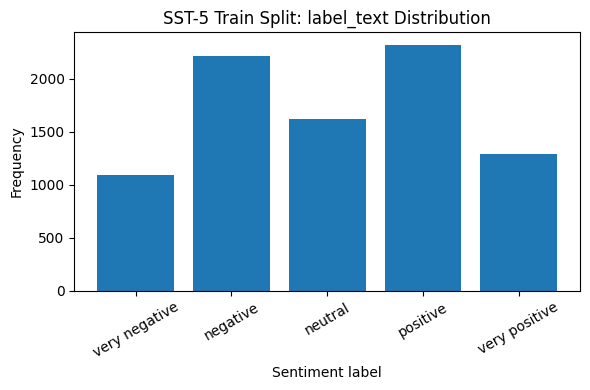


"Train" split label_text distribution:
  very negative: 1092
  negative     : 2218
  neutral      : 1624
  positive     : 2322
  very positive: 1288


In [6]:
import matplotlib.pyplot as plt
from collections import Counter

train_labels = [ex["label_text"] for ex in ds["train"]]
label_counts = Counter(train_labels)
ordered_labels = ["very negative", "negative", "neutral", "positive", "very positive"]
counts = [label_counts[label] for label in ordered_labels]

# --- Bar chart ---
plt.figure(figsize=(6,4))
plt.bar(ordered_labels, counts)
plt.xlabel("Sentiment label")
plt.ylabel("Frequency")
plt.title("SST-5 Train Split: label_text Distribution")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

print('\n"Train" split label_text distribution:')
for label, count in zip(ordered_labels, counts):
    print(f"  {label:13s}: {count}")


# III. Fine-tuning DistilBERT NLP model for movie review rating classification

For this project, we will download a pre-trained natural language processing model and then fine-tune it to adapt to movie review ratings using the Stanford SST-5 dataset..

* **Model Name**: distilbert/distilbert-base-uncased
* **Params**: Trained with 67M parameters
* **Size**: ~268 MB
* **Use Cases**: Text classification, sentiment analysis.
* **Tokenizer**: WordPiece, vocab size ~30K lower-case only(uncased)
* **HuggingFace**: [https://huggingface.co/distilbert/distilbert-base-uncased](https://huggingface.co/distilbert/distilbert-base-uncased)




In [7]:
from transformers import AutoTokenizer, DataCollatorWithPadding
import numpy as np, evaluate

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Even though max length of 'text' field is 255
# number of converted tokens should be much less than 128
def preprocess(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=128,
    )

tokenized_ds = ds.map(preprocess, batched=True)
tokenized_ds = tokenized_ds.rename_column("label", "labels")
tokenized_ds.set_format(type="torch")
#, columns=["input_ids", "attention_mask", "labels"])

data_collator = DataCollatorWithPadding(tokenizer)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [8]:
from transformers import AutoModelForSequenceClassification

pairs = {}
for lbl, lbl_txt in zip(ds["train"]["label"], ds["train"]["label_text"]):
    if lbl not in pairs:
        pairs[int(lbl)] = lbl_txt

# Sort by numeric label ID just to be safe
id2label = {k: pairs[k] for k in sorted(pairs.keys())}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id,
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import transformers
from transformers import TrainingArguments, Trainer
print(transformers.__version__)

training_args = TrainingArguments(
    output_dir="./sst2-distilbert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    logging_dir='./logs',
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()


4.57.1


/tmp/ipython-input-2210952062.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.174383,0.485014,0.452012
2,1.181200,1.159466,0.482289,0.467989
3,1.181200,1.169203,0.484105,0.473761


TrainOutput(global_step=801, training_loss=1.0918719307164872, metrics={'train_runtime': 115.0378, 'train_samples_per_second': 222.814, 'train_steps_per_second': 6.963, 'total_flos': 339896411838720.0, 'train_loss': 1.0918719307164872, 'epoch': 3.0})

,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,loss,grad_norm,learning_rate,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.174383,0.485014,0.452012,1.4861,740.843,23.551,1.000000,267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,1.872659,500,1.1812,7.011508,0.000008,NaN,NaN,NaN,NaN,NaN
2,1.159466,0.482289,0.467989,1.4749,746.467,23.730,2.000000,534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.169203,0.484105,0.473761,1.5614,705.141,22.416,3.000000,801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,801,NaN,NaN,NaN,115.0378,222.814,6.963,3.398964e+14,1.091872


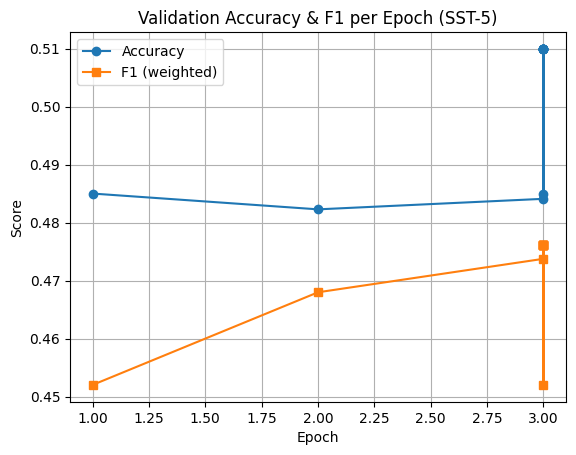

In [19]:
# Plot training loss vs epoch
import matplotlib.pyplot as plt

history = trainer.state.log_history
log_df = pd.DataFrame(history)
display(log_df.head())

eval_df = log_df[log_df["eval_accuracy"].notnull()]

plt.figure()
plt.plot(eval_df["epoch"], eval_df["eval_accuracy"], marker="o", label="Accuracy")
plt.plot(eval_df["epoch"], eval_df["eval_f1"], marker="s", label="F1 (weighted)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Accuracy & F1 per Epoch (SST-5)")
plt.legend()
plt.grid(True)
plt.show()


# IV. Validate with accuracy measurement

- Use the fine-tuned DistilBERT model to evaluate on the **validation** and **test** splits of SST-5.
- Call `trainer.evaluate()` to compute key metrics, including **accuracy**, **F1 (weighted)**, and **loss**.
- Compare **validation vs. test accuracy** to check how well the model generalizes beyond the training data.
- This comparison result can be use to determine if re-training is required.


In [14]:
validation_results = trainer.evaluate(tokenized_ds["test"])
print("Valiation set results:")
print("-------------\n")
for k, v in validation_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
print("\n")

test_results = trainer.evaluate(tokenized_ds["test"])
print("Test set results:")
print("-------------\n")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
print("\n")

Valiation set results:
-------------

eval_loss: 1.1309
eval_accuracy: 0.5100
eval_f1: 0.4762
eval_runtime: 3.1607
eval_samples_per_second: 699.2140
eval_steps_per_second: 22.1470
epoch: 3.0000


Test set results:
-------------

eval_loss: 1.1309
eval_accuracy: 0.5100
eval_f1: 0.4762
eval_runtime: 3.1048
eval_samples_per_second: 711.7940
eval_steps_per_second: 22.5460
epoch: 3.0000




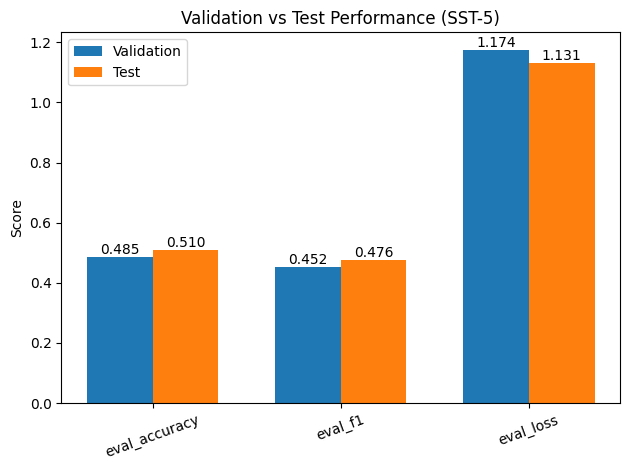

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# --- Build comparison chart (validation vs test) ---
metric_keys = ["eval_accuracy", "eval_f1", "eval_loss"]
val_values = [validation_results[m] for m in metric_keys]
test_values = [test_results[m] for m in metric_keys]

x = np.arange(len(metric_keys))
width = 0.35

plt.figure()
plt.bar(x - width/2, val_values, width, label="Validation")
plt.bar(x + width/2, test_values, width, label="Test")

plt.xticks(x, metric_keys, rotation=20)
plt.ylabel("Score")
plt.title("Validation vs Test Performance (SST-5)")
plt.legend()
plt.tight_layout()

for i, v in enumerate(val_values):
    plt.text(x[i] - width/2, v, f"{v:.3f}", ha="center", va="bottom")
for i, v in enumerate(test_values):
    plt.text(x[i] + width/2, v, f"{v:.3f}", ha="center", va="bottom")

plt.show()


# V. Save model and tokenizer

- Save the **fine-tuned model weights** and configuration to be used for production inference.
- Save the tokenizer files to the same directory so inference code can encode text exactly as during training.
- Keep track of the model version and training parameters for reproducibility and future updates.



In [20]:
# save model for online dockerization

save_dir = "./distilbert-sst5-finetuned"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"Saved model and tokenizer to: {save_dir}")


Saved model and tokenizer to: ./distilbert-sst5-finetuned


# Vi. Reference:

* Model page: [https://huggingface.co/samadpls/sentiment-analysis](https://huggingface.co/samadpls/sentiment-analysis)

* DataSet: [https://huggingface.co/datasets/SetFit/sst5](https://huggingface.co/datasets/SetFit/sst5)

* Source: [https://nlp.stanford.edu/sentiment/](https://nlp.stanford.edu/sentiment/)